In [1]:
import sys
sys.path.append("../")

import os
import sqlite3
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from tqdm import tqdm
import bisect

from src.cmesrc.config import CMESRCV2_DB, CMESRCV3_DB, HARPNUM_TO_NOAA, LASCO_CME_DATABASE, SDOML_TIMESTAMP_INFO,SPATIOTEMPORAL_MATCHING_HARPS_DATABASE_PICKLE, DIMMINGS_MATCHED_TO_HARPS_PICKLE, FLARES_MATCHED_TO_HARPS_PICKLE
from src.cmesrc.utils import read_SWAN_filepath, filepaths_updated_swan_data

In [2]:
# Delete CMESRCV3_DB if exists
if os.path.exists(CMESRCV3_DB) and False:
    os.remove(CMESRCV3_DB)

# Create CMESRCV3_DB
new_conn = sqlite3.connect(CMESRCV3_DB)
new_cur = new_conn.cursor()

# Also open CMESRCV2_DB
old_conn = sqlite3.connect(CMESRCV2_DB)
old_cur = old_conn.cursor()

In [4]:
# Now we need to add the schema to the db

new_cur.executescript("""
CREATE TABLE HARPS (
  harpnum INTEGER PRIMARY KEY,                    -- Unique identifier for each HARP region
  start TEXT NOT NULL, -- Start timestamp of the HARP region
  end TEXT NOT NULL,  -- End timestamp of the HARP region
  pix_width INTEGER, -- Refers to the fixed width in pixel values used for cutouts
  pix_height INTEGER, -- Refers to the fixed height in pixel values used for cutouts
  area FLOAT, -- Refers to the area of the HARP region
  n_noaas INTEGER, -- Refers to the maximum number of NOAA active regions in the HARP region
  CHECK (area >= 0),
  CHECK (pix_width >= 0),
  CHECK (pix_height >= 0),
  CHECK (end >= start)
);
CREATE TABLE CMES (
  cme_id INTEGER NOT NULL PRIMARY KEY,            -- Unique identifier for each CME
  cme_date TEXT NOT NULL,                         -- Date and time of the CME
  cme_pa REAL,                                    -- Position angle of the CME
  cme_width REAL NOT NULL,                        -- Width of the CME
  cme_halo INTEGER,                               -- Indicator for Halo CMEs (1 for Halo, else NULL)
  cme_seen_in INTEGER NOT NULL,                   -- Where the CME was observed (e.g., C2, C3)
  cme_three_points INTEGER NOT NULL,              -- Number of observed points for the CME
  cme_quality INTEGER NOT NULL,                   -- Quality rating for the CME observation
  image_timestamp TEXT REFERENCES IMAGES (timestamp), -- Timestamp of the associated image
  CHECK (
    ((cme_pa IS NULL) = (cme_halo = 1))           -- Ensure Halo CMEs don't have a position angle
  )
);
CREATE TABLE FLARES (
  flare_id INTEGER NOT NULL PRIMARY KEY,          -- Unique identifier for each flare
  harpnum INTEGER REFERENCES HARPS (harpnum),     -- Associated HARP region
  flare_date TEXT NOT NULL,                       -- Date and time of the flare
  flare_lon REAL,                                 -- Longitude of the flare
  flare_lat REAL,                                 -- Latitude of the flare
  flare_class_score REAL NOT NULL,                -- Score indicating the class of the flare
  flare_class TEXT NOT NULL,                      -- Class of the flare (e.g., M1, X2)
  flare_ar INTEGER,                               -- Active Region number of the flare
  flare_ar_source TEXT,                           -- Source of the Active Region number
  flare_verification TEXT,                        -- Verification status of the flare information
  image_timestamp TEXT REFERENCES IMAGES(timestamp), -- Timestamp of the associated image
  CHECK (
    (flare_ar IS NULL AND flare_lon IS NOT NULL AND flare_lat IS NOT NULL) OR
    (flare_ar IS NOT NULL)                        -- Ensure either flare_ar or both flare_lon and flare_lat are provided
  )
);
CREATE TABLE IMAGES (
  timestamp TEXT NOT NULL UNIQUE,                 -- Unique timestamp for each image
  year INTEGER NOT NULL,                          -- Year the image was captured
  month INTEGER NOT NULL,                         -- Month the image was captured
  day INTEGER NOT NULL,                           -- Day of the month the image was captured
  hour INTEGER NOT NULL,                          -- Hour of the day the image was captured
  minute INTEGER NOT NULL,                        -- Minute of the hour the image was captured
  second INTEGER NOT NULL,                        -- Second of the minute the image was captured
  idx INTEGER NOT NULL                            -- Index to access the image in the zarr format
);
CREATE TABLE RAW_HARPS_BBOX (
    -- Reference to the harpnum column in the harps table
    harpnum INTEGER REFERENCES HARPS (harpnum), 
    -- Reference to the timestamp column in the images table
    timestamp TEXT, 
    -- Minimum longitude of BBOX
    LONDTMIN REAL, 
    -- Maximum longitude of BBOX
    LONDTMAX REAL, 
    -- Minimum latitude of BBOX
    LATDTMIN REAL, 
    -- Maximum latitude of BBOX
    LATDTMAX REAL, 
    -- Is Rotated Bounding Box? Specifies if the BBOX is calculated using differential solar rotation because it was missing from the SHARP dataset
    IRBB INTEGER, 
    -- Is trusted magnetic field data?
    IS_TMFI INTEGER,
    PRIMARY KEY (harpnum, timestamp),
    -- Need to check that the timestamp has minutes 12, 24, 36, 48, or 00
    CHECK (strftime('%M', timestamp) IN ('12', '24', '36', '48', '00'))
);
CREATE TABLE PROCESSED_HARPS_PIXEL_BBOX (
    -- Reference to the harpnum column in the harps table
    harpnum INTEGER REFERENCES HARPS (harpnum),
    -- Reference to the timestamp column in the images table
    timestamp TEXT, 
    -- Minimum x-coordinate of the bounding box; value must be between 0 and 511
    x_min INTEGER NOT NULL CHECK (x_min >= 0 AND x_min <= 511), 
    -- Maximum x-coordinate of the bounding box; value must be between 0 and 511
    x_max INTEGER NOT NULL CHECK (x_max >= 0 AND x_max <= 511), 
    -- Minimum y-coordinate of the bounding box; value must be between 0 and 511
    y_min INTEGER NOT NULL CHECK (y_min >= 0 AND y_min <= 511), 
    -- Maximum y-coordinate of the bounding box; value must be between 0 and 511
    y_max INTEGER NOT NULL CHECK (y_max >= 0 AND y_max <= 511), 
    -- x-coordinate of the center of the bounding box; value must be between 0 and 511
    x_cen INTEGER NOT NULL CHECK (x_cen >= 0 AND x_cen <= 511), 
    -- y-coordinate of the center of the bounding box; value must be between 0 and 511
    y_cen INTEGER NOT NULL CHECK (y_cen >= 0 AND y_cen <= 511), overlap_percent REAL, overlap_harpnum INTEGER, area REAL, 
    -- Unique key for the table based on harpnum and timestamp
    PRIMARY KEY (harpnum, timestamp),
    -- References the harps_bbox table to maintain a relationship with HARPS bounding box information
    FOREIGN KEY (harpnum, timestamp) REFERENCES HARPS_BBOX (harpnum, timestamp)
);
CREATE TABLE FINAL_CME_HARP_ASSOCIATIONS (
  cme_id INTEGER UNIQUE NOT NULL REFERENCES CMES(cme_id),                 -- Unique identifier for each CME
  harpnum INTEGER NOT NULL REFERENCES HARPS(harpnum),                       -- Associated HARP region
  association_method TEXT NOT NULL,               -- Method used to determine the association
  verification_score REAL,                        -- Confidence score of the association
  independent_verified INTEGER NOT NULL DEFAULT 0, -- Verification level for association (0 if only by me, 1 if verified by external)
  PRIMARY KEY (cme_id, harpnum)                   -- Unique pairing of CME and HARP
);
CREATE TABLE BBOX_OVERLAPS (
    harpnum_a INTEGER REFERENCES HARPS(harpnum),
    harpnum_b INTEGER REFERENCES HARPS(harpnum),
    mean_overlap REAL,
    mean_pixel_overlap REAL,
    ocurrence_percentage REAL,
    pixel_ocurrence_percentage REAL,
    harpnum_a_area REAL,
    harpnum_a_pixel_area REAL,
    harpnum_b_area REAL,
    coexistence REAL
);
CREATE TABLE OVERLAP_RECORDS (
            harpnum_a INTEGER REFERENCES HARPS(harpnum),
            harpnum_b INTEGER REFERENCES HARPS(harpnum),
            decision STRING,
            mean_overlap REAL,
            std_overlap REAL,
            ocurrence_percentage REAL,
            harpnum_a_area REAL,
            harpnum_b_area REAL,
            b_over_a_area_ratio REAL,
            PRIMARY KEY (harpnum_a, harpnum_b),
            CHECK (harpnum_a_area < harpnum_b_area),
            CHECK (decision IN ('MERGED A WITH B', 'DELETED A IN FAVOR OF B'))
);
CREATE TABLE PROCESSED_HARPS_BBOX(
    -- Reference to the harpnum column in the harps table
    harpnum INTEGER REFERENCES HARPS (harpnum), 
    -- Reference to the timestamp column in the images table
    timestamp TEXT, 
    -- Minimum longitude of BBOX
    LONDTMIN REAL, 
    -- Maximum longitude of BBOX
    LONDTMAX REAL, 
    -- Minimum latitude of BBOX
    LATDTMIN REAL, 
    -- Maximum latitude of BBOX
    LATDTMAX REAL, 
    -- Is Rotated Bounding Box? Specifies if the BBOX is calculated using differential solar rotation because it was missing from the SHARP dataset
    IRBB INTEGER, 
    -- Is trusted magnetic field data?
    IS_TMFI INTEGER,
    PRIMARY KEY (harpnum, timestamp),
    -- Need to check that the timestamp has minutes 12, 24, 36, 48, or 00
    CHECK (strftime('%M', timestamp) IN ('12', '24', '36', '48', '00'))
);
CREATE TABLE MAJUMDAR_SRC (
             cme_id INTEGER PRIMARY KEY REFERENCES CMES (cme_id),
             cme_date TEXT NOT NULL,
             cme_pa REAL,
             cme_width REAL,
             cme_speed REAL,
             sr_type TEXT,
             sr_lat REAL NOT NULL,
             sr_lon REAL NOT NULL
    , matching_harps INTEGER REFERENCES HARPS (harpnum) DEFAULT NULL, dist REAL, sr_pa REAL);
CREATE TABLE IF NOT EXISTS CMES_HARPS_EVENTS (
	harpnum	INTEGER,
	cme_id	INTEGER,
	flare_id	INTEGER REFERENCES FLARES(flare_id),
	flare_hours_diff	INTEGER NOT NULL,
	dimming_id	INTEGER REFERENCES DIMMINGS(dimming_id),
	dimming_hours_diff	INTEGER NOT NULL,
	FOREIGN KEY(harpnum,cme_id) REFERENCES CMES_HARPS_SPATIALLY_CONSIST(harpnum,cme_id),
	PRIMARY KEY(harpnum,cme_id)
);
CREATE TABLE IF NOT EXISTS CMES_HARPS_SPATIALLY_CONSIST (
	harpnum	INTEGER NOT NULL REFERENCES HARPS(harpnum),
	cme_id	INTEGER NOT NULL REFERENCES CMES(cme_id),
	PRIMARY KEY(harpnum,cme_id)
);
CREATE TABLE IF NOT EXISTS DIMMINGS (
	dimming_id	INTEGER NOT NULL,
	harpnum	INTEGER REFERENCES HARPS(harpnum),
	harps_dimming_dist	REAL NOT NULL,
	dimming_start_date	TEXT NOT NULL,
	dimming_peak_date	TEXT NOT NULL,
	dimming_lon	REAL NOT NULL,
	dimming_lat	REAL NOT NULL,
	image_timestamp	TEXT REFERENCES IMAGES(timestamp),
	PRIMARY KEY(dimming_id)
);
CREATE TABLE NOAA_HARPNUM_MAPPING (
        noaa INTEGER,
        harpnum INTEGER REFERENCES HARPS (harpnum),
        PRIMARY KEY (noaa, harpnum)
        );
CREATE TABLE NOAAS (
    noaa INTEGER PRIMARY KEY
);
CREATE TABLE SANJIV_SRC (
        cme_id INTEGER PRIMARY KEY REFERENCES CMES (cme_id),
        cme_date TEXT,
        cme_width REAL,
        cme_speed REAL,
        flare_time TEXT,
        flare_class TEXT,
        noaa INTEGER REFERENCES NOAAS (noaa)
        );
CREATE TABLE HOURLY_BBOX(
    -- Reference to the harpnum column in the harps table
    harpnum INTEGER REFERENCES HARPS (harpnum), 
    -- Reference to the timestamp column in the images table
    timestamp TEXT, 
    -- Minimum longitude of BBOX
    LONDTMIN REAL, 
    -- Maximum longitude of BBOX
    LONDTMAX REAL, 
    -- Minimum latitude of BBOX
    LATDTMIN REAL, 
    -- Maximum latitude of BBOX
    LATDTMAX REAL, 
    -- Is Rotated Bounding Box? Specifies if the BBOX is calculated using differential solar rotation because it was missing from the SHARP dataset
    IRBB INTEGER, 
    -- Is trusted magnetic field data?
    IS_TMFI INTEGER,
    PRIMARY KEY (harpnum, timestamp),
    -- Need to check that the timestamp has minutes 12, 24, 36, 48, or 00
    CHECK (strftime('%M', timestamp) IN ('12', '24', '36', '48', '00'))
);
CREATE TABLE HOURLY_PIXEL_BBOX(
    -- Reference to the harpnum column in the harps table
    harpnum INTEGER REFERENCES HARPS (harpnum), 
    -- Reference to the timestamp column in the images table
    timestamp TEXT, 
    -- Minimum x-coordinate of the bounding box; value must be between 0 and 511
    x_min INTEGER NOT NULL CHECK (x_min >= 0 AND x_min <= 511), 
    -- Maximum x-coordinate of the bounding box; value must be between 0 and 511
    x_max INTEGER NOT NULL CHECK (x_max >= 0 AND x_max <= 511), 
    -- Minimum y-coordinate of the bounding box; value must be between 0 and 511
    y_min INTEGER NOT NULL CHECK (y_min >= 0 AND y_min <= 511), 
    -- Maximum y-coordinate of the bounding box; value must be between 0 and 511
    y_max INTEGER NOT NULL CHECK (y_max >= 0 AND y_max <= 511), 
    -- x-coordinate of the center of the bounding box; value must be between 0 and 511
    x_cen INTEGER NOT NULL CHECK (x_cen >= 0 AND x_cen <= 511), 
    -- y-coordinate of the center of the bounding box; value must be between 0 and 511
    y_cen INTEGER NOT NULL CHECK (y_cen >= 0 AND y_cen <= 511), overlap_percent REAL, overlap_harpnum INTEGER, area REAL, 
    -- Unique key for the table based on harpnum and timestamp
    PRIMARY KEY (harpnum, timestamp),
    -- References the harps_bbox table to maintain a relationship with HARPS bounding box information
    FOREIGN KEY (harpnum, timestamp) REFERENCES HARPS_BBOX (harpnum, timestamp)
);
CREATE TABLE HARPS_DATASET_SLICES (
                    slice_id INTEGER PRIMARY KEY AUTOINCREMENT,
                    harpnum INTEGER NOT NULL REFERENCES HARPS(harpnum),
                    lead_in_start TEXT NOT NULL,
                    lead_in_end TEXT NOT NULL,
                    obs_start TEXT NOT NULL,
                    obs_end TEXT NOT NULL,
                    pred_start TEXT NOT NULL,
                    pred_end TEXT NOT NULL,
                    prev_cme_id INTEGER REFERENCES CMES(cme_id),
                    prev_cme_diff REAL,
                    label INTEGER NOT NULL,
                    cme_diff REAL,
                    verification_level INTEGER,
                    cme_id INTEGER REFERENCES CMES(cme_id),
                    n_images INTEGER NOT NULL
                    );
CREATE TABLE HARPS_DATASET_REJECTED_SLICES (
                    slice_id INTEGER PRIMARY KEY AUTOINCREMENT,
                    harpnum INTEGER NOT NULL REFERENCES HARPS(harpnum),
                    lead_in_start TEXT NOT NULL,
                    lead_in_end TEXT NOT NULL,
                    obs_start TEXT NOT NULL,
                    obs_end TEXT NOT NULL,
                    pred_start TEXT NOT NULL,
                    pred_end TEXT NOT NULL,
                    reason TEXT NOT NULL,
                    message TEXT NOT NULL
                    );
""")

new_conn.commit()

In [5]:
# Now we need to get the filepaths for the updated SWAN data
swan_filepaths = filepaths_updated_swan_data()


==CACHING SWAN DATA.==



100%|██████████| 4098/4098 [00:00<00:00, 822837.75it/s]

In [6]:
# Now read the data from the swan files into the database

new_cur.execute("DELETE FROM RAW_HARPS_BBOX;")

for harpnum in tqdm(swan_filepaths.keys()):
    filepath = swan_filepaths[harpnum]
    data = read_SWAN_filepath(filepath)
    # Replace the NaN values with 0
    data["IS_TMFI"] = data["IS_TMFI"].fillna(0)
    data = [(int(harpnum), str(row["Timestamp"])[:-4], float(row["LONDTMIN"]), float(row["LONDTMAX"]), float(row["LATDTMIN"]), float(row["LATDTMAX"]), int(row["IRBB"]), int(row["IS_TMFI"])) for i, row in data.iterrows()]

    # Insert the data into the database RAW_HARPS_BBOX table
    new_cur.executemany("""
    INSERT INTO RAW_HARPS_BBOX (harpnum, timestamp, LONDTMIN, LONDTMAX, LATDTMIN, LATDTMAX, IRBB, IS_TMFI)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?);
    """, data)
new_conn.commit()

100%|██████████| 4098/4098 [04:45<00:00, 14.36it/s]


In [7]:
# And we add the Harps to harpnums

new_cur.execute("DELETE FROM HARPS;")
new_cur.execute("SELECT harpnum, min(timestamp) as start, max(timestamp) as end FROM RAW_HARPS_BBOX GROUP BY harpnum;")

data = new_cur.fetchall()

data = [(int(row[0]), str(row[1]), str(row[2])) for row in data]

for row in data:
    new_cur.execute("""
    INSERT INTO HARPS (harpnum, start, end)
    VALUES (?, ?, ?);
    """, row)
        

new_conn.commit()

In [8]:
# Now we need to calculate the areas.
# Later on I will modify bounding boxes by
# cutting them so they don't go behind the limb.
# So areas, given I calculate mean areas, will be
# calculated now so they're not distorted

new_cur.execute("""
WITH AREAS AS (
                SELECT harpnum,
                COALESCE(AVG(NULLIF(100.0 * ((PI()/180.0 * (LONDTMAX - LONDTMIN) * ABS(SIN(PI()/180.0 * LATDTMAX) - SIN(PI()/180.0 * LATDTMIN))) / (2.0 * PI())), 0)),0) AS area
                FROM RAW_HARPS_BBOX
                GROUP BY harpnum
                )
UPDATE HARPS
SET area = (SELECT area FROM AREAS WHERE AREAS.harpnum = HARPS.harpnum);
                """)

new_conn.commit()

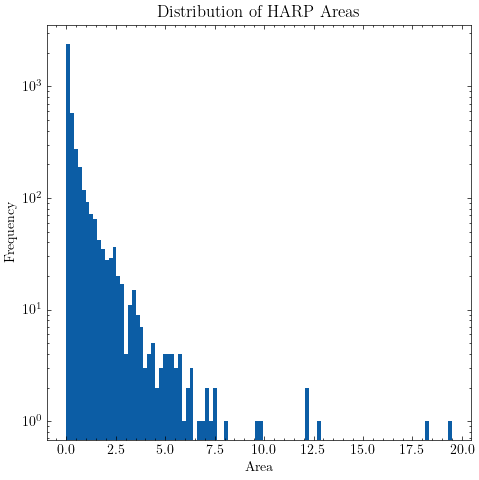

In [9]:
areas = pd.read_sql_query("SELECT * FROM HARPS;", new_conn)

# Plot the distribution of areas nicely

plt.style.use("science")
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(areas["area"], bins=100, log=True)
ax.set_xlabel("Area %")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of HARP Areas")
plt.tight_layout()
# Save as svg and embed fonts so it looks nice in the blog
plt.savefig("/home/julio/research_log/content/images/18_09_23_code_journey_src/sharp_areas.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)

In [10]:
# We just copy the NOAA_AR to HARPS_AR association table as it's taken directly from http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt

new_cur.execute("DELETE FROM NOAA_HARPNUM_MAPPING;")
new_cur.execute("DELETE FROM NOAAS;")

noaatoharp = pd.read_csv(HARPNUM_TO_NOAA, sep=" ", header=0)

def parse_noaa_lists(noaa_list):
    return [int(noaa) for noaa in noaa_list.split(",")]

noaatoharp["noaa_list"] = noaatoharp["NOAA_ARS"].apply(parse_noaa_lists)

for _, row in noaatoharp.iterrows():
    for noaa in row["noaa_list"]:
        if int(row["HARPNUM"]) > 7331.5:
            continue
        try:
            new_cur.execute("""
                INSERT INTO NOAA_HARPNUM_MAPPING (noaa, harpnum)
                VALUES (?, ?)
            """, (int(noaa), int(row["HARPNUM"])))
        except sqlite3.IntegrityError as e:
            print(f"Integrity error for {noaa}, {row['HARPNUM']}")

new_cur.execute("""
INSERT INTO NOAAS (noaa)
SELECT DISTINCT noaa
FROM NOAA_HARPNUM_MAPPING
""")

new_conn.commit()

In [11]:
# Now let's try to get for each HARP the maximum number of NOAA active regions

new_cur.execute("""
UPDATE HARPS
SET n_noaas = (SELECT COUNT(noaa)
               FROM NOAA_HARPNUM_MAPPING
               WHERE NOAA_HARPNUM_MAPPING.harpnum = HARPS.harpnum)
    """)


new_conn.commit()

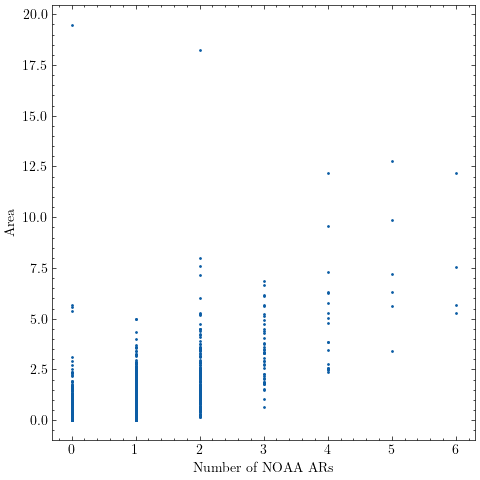

In [12]:
# And then plot the area vs number of NOAA active regions

noaa_areas = pd.read_sql_query("""
SELECT area, n_noaas
FROM HARPS
""", new_conn)

plt.style.use("science")

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(noaa_areas["n_noaas"], noaa_areas["area"], s=1)
ax.set_ylabel("Area %")
ax.set_xlabel("Number of NOAA ARs")
plt.tight_layout()
plt.savefig("/home/julio/research_log/content/images/18_09_23_code_journey_src/noaa_n_areas.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)

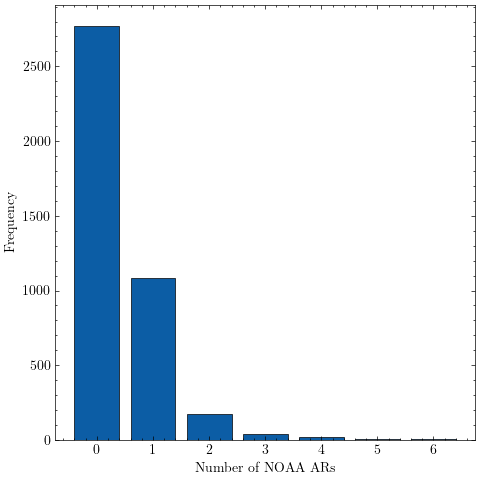

In [13]:
# And the distribution of NOAA ARs number. Obviusly each bin should be e.g 0 noaa ars, 1 noaa ar, 2 noaa ars, etc
# And x ticks should be at 0, 1, 2, 3, 4, 5, 6
# The bins should be centred at integer values

plt.style.use("science")

fig, ax = plt.subplots(figsize=(5, 5))

bins = [i - 0.5 for i in range(0, 8)]
ticks = [i for i in range(0, 7)]

# Make bars pretty with a border
ax.hist(noaa_areas["n_noaas"], bins=bins, log=False, rwidth=0.8, align="mid", edgecolor="black", linewidth=0.5)
ax.set_xticks(ticks)

ax.set_xlabel("Number of NOAA ARs")
ax.set_ylabel("Frequency")

plt.tight_layout()

plt.savefig("/home/julio/research_log/content/images/18_09_23_code_journey_src/noaa_n_areas_hist.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)

In [14]:
# Sample some random bounding boxes where the LONDTMIN < -90 or LONDTMAX > 90 but not both

# Random 5
df = pd.read_sql("""
SELECT RHB.harpnum, RHB.timestamp, RHB.LONDTMIN, RHB.LONDTMAX, RHB.LATDTMIN, RHB.LATDTMAX
FROM RAW_HARPS_BBOX RHB
INNER JOIN HARPS H ON H.harpnum = RHB.harpnum
WHERE H.area > 18 AND ((RHB.LONDTMIN < -90 AND RHB.LONDTMAX < 90) OR (RHB.LONDTMIN > -90 AND RHB.LONDTMAX > 90))
ORDER BY RANDOM()
LIMIT 5
""", new_conn)

df

# To markdown, save to file
df.to_markdown("/home/julio/Downloads/lon_bboxes.md", index=False)

In [15]:
# Calculating the overlaps is a step by step process

# 1. We remove too big harps

new_cur.execute("CREATE INDEX IF NOT EXISTS idx_harps_area ON HARPS (area);")
new_cur.execute("CREATE INDEX IF NOT EXISTS idx_harps_harpnum ON HARPS (area);")

new_cur.execute("DROP TABLE IF EXISTS NO_BIG_HARPS;")
new_cur.execute("""
CREATE TEMPORARY TABLE NO_BIG_HARPS AS
                SELECT RHB.* FROM RAW_HARPS_BBOX RHB
                INNER JOIN HARPS H ON RHB.harpnum = H.harpnum
                WHERE H.area < 18
                """)
    
# 2. We trim the bounding boxes that extend beyond the limb

new_cur.execute("CREATE INDEX IF NOT EXISTS idx_no_big_harps_harpnum ON NO_BIG_HARPS (LONDTMIN);")
new_cur.execute("CREATE INDEX IF NOT EXISTS idx_no_big_harps_harpnum ON NO_BIG_HARPS (LONDTMAX);")

new_cur.execute("DROP TABLE IF EXISTS TRIMMED_HARPS_BBOX;")
new_cur.execute("""
CREATE TEMPORARY TABLE TRIMMED_HARPS_BBOX AS
SELECT NBH.* FROM NO_BIG_HARPS NBH
""")

# Now whenever LONDTMIN < -90 we set it to -90
# Whenever LONDTMAX > 90 we set it to 90
# And if LONTMIN<-90 AND LONDTMIN < -90 we drop that row
# And if LONTMIN>90 AND LONDTMIN > -90 we drop that row

new_cur.execute("""
DELETE FROM TRIMMED_HARPS_BBOX
WHERE (LONDTMIN < -90 AND LONDTMAX < -90)
OR (LONDTMIN > 90 AND LONDTMAX > 90)
""")

new_cur.execute("""
UPDATE TRIMMED_HARPS_BBOX
SET LONDTMIN = -90
WHERE LONDTMIN < -90
""")

new_cur.execute("""
UPDATE TRIMMED_HARPS_BBOX
SET LONDTMAX = 90
WHERE LONDTMAX > 90
""")

In [16]:
# 3. Now we need to calculate the actual overlaps

new_cur.executescript("""
-- Create an index on HARPS_BBOX for the join in the temp_overlap creation step
CREATE INDEX IF NOT EXISTS idx_thbb_harpnum_timestamp ON TRIMMED_HARPS_BBOX(harpnum, timestamp);

-- Create temporary table with overlap info
CREATE TEMPORARY TABLE temp_overlap AS
SELECT
    a.harpnum AS harpnum1,
    b.harpnum AS harpnum2,
    a.timestamp AS timestamp,
    100.0 * CASE WHEN a.LONDTMIN < b.LONDTMAX AND a.LONDTMAX > b.LONDTMIN AND a.LATDTMIN < b.LATDTMAX AND a.LATDTMAX > b.LATDTMIN
        THEN (MIN(a.LONDTMAX, b.LONDTMAX) - MAX(a.LONDTMIN, b.LONDTMIN)) * ABS((SIN(PI() / 180.0 * MIN(a.LATDTMAX, b.LATDTMAX)) - SIN(PI() / 180.0 * MAX(a.LATDTMIN, b.LATDTMIN))))
        ELSE 0
    END / ((2.0 * PI() / (100.0 * PI() / 180.0)) * H.area) AS overlap_percent
FROM TRIMMED_HARPS_BBOX a
JOIN TRIMMED_HARPS_BBOX b ON a.timestamp = b.timestamp AND a.harpnum != b.harpnum
JOIN HARPS H ON H.harpnum = a.harpnum;

-- Create an index on temp_overlap for the window function in the temp_largest_overlap creation step
CREATE INDEX IF NOT EXISTS idx_temp_overlap_harpnum1_timestamp_overlap ON temp_overlap(harpnum1, timestamp, overlap_percent DESC);

DROP TABLE IF EXISTS avg_overlap;
DROP TABLE IF EXISTS OVERLAPS;

CREATE TEMP TABLE avg_overlap AS
    SELECT tpo.harpnum1 as harpnum_a, tpo.harpnum2 as harpnum_b, AVG(tpo.overlap_percent) AS mean_overlap,
    (100.0 * (COUNT(tpo.timestamp) - 1) * 12.0 * 60.0) / (1.0 * NULLIF(strftime('%s', H.end) - strftime('%s', H.start), 0)) AS ocurrence_percentage
    FROM temp_overlap tpo
    JOIN HARPS H ON H.harpnum = tpo.harpnum1
    WHERE tpo.overlap_percent > 0
    GROUP BY harpnum1, harpnum2;

CREATE TABLE OVERLAPS AS
    SELECT ao.*,
    -- Standard deviation of the overlap
    SQRT(SUM((tpo.overlap_percent - ao.mean_overlap) * (tpo.overlap_percent - ao.mean_overlap)) / (COUNT(tpo.timestamp) - 1)) AS std_overlap
    FROM avg_overlap ao
    INNER JOIN TEMP_OVERLAP tpo ON ao.harpnum_a = tpo.harpnum1 AND ao.harpnum_b = tpo.harpnum2
    GROUP BY harpnum_a, harpnum_b;
""")

new_conn.commit()

In [17]:
# Select random 20 entries from avg_overlap

df = pd.read_sql("""
SELECT * FROM avg_overlap
ORDER BY avg_overlap.mean_overlap DESC
""", new_conn)

df["diff"] = df["ocurrence_percentage"] - df["alternative_ocurrence_percentage"]
different = df[df["ocurrence_percentage"] != df["alternative_ocurrence_percentage"]]

# To html, no indices and with only 2 decimal places
different.to_html("/home/julio/Downloads/overlap_diff.html", index=False, float_format="{:.2f}".format)

df[(df["mean_overlap"] < 95) & (df["ocurrence_percentage"] < 80)]

KeyError: 'alternative_ocurrence_percentage'

In [ ]:
# Select from temp_overlap where harpnum1 = 1698 and harpnum2 = 1694

df = pd.read_sql("""
SELECT * FROM temp_overlap
WHERE harpnum1 = 2567 AND harpnum2 = 2520
""", new_conn)

# And I want to know if there are breaks in the timestamps (should be spaced every 12 minutes)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df["diff"] = df["timestamp"].diff()

# Are there any breaks in time? (any diff != 12 minutes)
breaks = len(df[df["diff"] != pd.Timedelta("12 minutes")]) > 0
print(f"Are there any breaks in time? {breaks}")

orig = df["timestamp"].max() - df["timestamp"].min()
alt = len(df) * pd.Timedelta("12 minutes")

# See with diff where the breaks are

df[df["diff"] != pd.Timedelta("12 minutes")]

Are there any breaks in time? True


,harpnum1,harpnum2,timestamp,overlap_percent,diff
0,2567,2520,2013-03-12 04:36:00,61.99568,NaT


KeyError: 'timestamp'

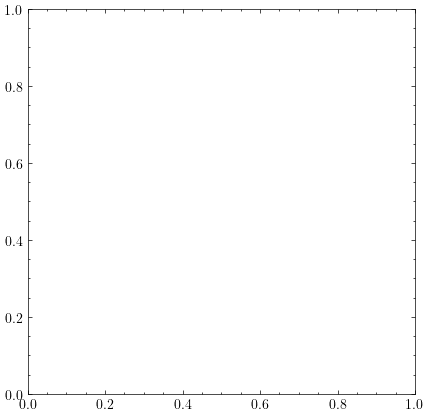

In [18]:
# Plot overlap percent vs time, smoothed

plt.style.use("science")

fig, ax = plt.subplots(figsize=(5, 5))

df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df.sort_values(by="timestamp")

df["smoothed"] = df["overlap_percent"].rolling(10).mean()

ax.plot(df["timestamp"], df["smoothed"], linewidth=0.5)

ax.set_xlabel("Timestamp")
ax.set_ylabel("Overlap %")
ax.set_title(f"HARPNUM1: 1698, HARPNUM2: 1694")

ax.set_ylim(0,100)

# Tilt the x ticks

plt.xticks(rotation=45)

# Save to svg

plt.tight_layout()

#plt.savefig("/home/julio/research_log/content/images/18_09_23_code_journey_src/overlap_percent_time.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)

In [19]:
import pandas as pd
df = pd.read_sql_query("SELECT * FROM avg_overlap;", new_conn)
df[(df["ocurrence_percentage"] > 0.9) & (df["mean_overlap"] > 50) & (df["mean_overlap"] < 99)]
df

,harpnum_a,harpnum_b,mean_overlap,ocurrence_percentage
0,23,25,11.843781,97.174254
1,24,25,4.537289,90.767519
2,25,23,11.139128,75.857843
3,25,24,10.814265,100.000000
4,49,51,4.716187,64.669739
...,...,...,...,...
2151,7297,7292,100.000000,100.000000
2152,7312,7316,5.234756,56.674473
2153,7313,7319,2.235746,8.975713
2154,7316,7312,24.710513,100.000000


In [20]:
# Drop all the temp tables created in the process

new_cur.execute("DROP TABLE IF EXISTS avg_overlap;")
new_cur.execute("DROP TABLE IF EXISTS temp_overlap;")

In [21]:

overlaps = pd.read_sql_query("""
                             SELECT O.*, H1.area as harpnum_a_area, H2.area as harpnum_b_area, H2.area / H1.area as b_over_a_area_ratio FROM OVERLAPS O
                             INNER JOIN HARPS H1 ON O.harpnum_a = H1.harpnum
                             INNER JOIN HARPS H2 ON O.harpnum_b = H2.harpnum
                             """, new_conn)

bad_overlaps = overlaps[((overlaps["mean_overlap"] > 50) & (overlaps["ocurrence_percentage"] > 50)) | (overlaps["mean_overlap"] == 100)]

for index, row in bad_overlaps.iterrows():
    occurence_percentage = row["ocurrence_percentage"]
    mean_overlap = row["mean_overlap"]
    harpnum_a = row["harpnum_a"]
    harpnum_b = row["harpnum_b"]
    harpnum_a_area = row["harpnum_a_area"]
    harpnum_b_area = row["harpnum_b_area"]

    if occurence_percentage > 70 and mean_overlap > 90:
        decision = "MERGED A WITH B"
    else:
        decision = "DELETED A IN FAVOR OF B"
    
    new_cur.execute("INSERT OR IGNORE INTO OVERLAP_RECORDS VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", (harpnum_a, harpnum_b, decision, mean_overlap, row["std_overlap"], occurence_percentage, harpnum_a_area, harpnum_b_area, row["b_over_a_area_ratio"]))

new_conn.commit()

In [22]:
# Now fill processed_harps_bbox

new_cur.executescript("""
DROP TABLE IF EXISTS PROCESSED_HARPS_BBOX;

CREATE TABLE PROCESSED_HARPS_BBOX AS
                      SELECT RHB.* FROM RAW_HARPS_BBOX RHB
                      INNER JOIN HARPS H
                      ON RHB.harpnum = H.harpnum
                      WHERE H.area < 18 AND RHB.harpnum NOT IN (SELECT harpnum_a FROM OVERLAP_RECORDS);

DELETE FROM PROCESSED_HARPS_BBOX
WHERE (LONDTMIN < -90 AND LONDTMAX < -90)
OR (LONDTMIN > 90 AND LONDTMAX > 90);

UPDATE PROCESSED_HARPS_BBOX
SET LONDTMIN = -90
WHERE LONDTMIN < -90;

UPDATE PROCESSED_HARPS_BBOX
SET LONDTMAX = 90
WHERE LONDTMAX > 90;
""")

new_conn.commit()

In [23]:
# Loading the LASCO CME data

df = pd.read_csv(LASCO_CME_DATABASE)

df[df.duplicated(subset="CME_ID", keep=False)]

,CME_ID,CME_DATE,CME_PA,CME_WIDTH,CME_LINEAR_SPEED,CME_2ND_ORDER_INITIAL_SPEED,CME_2ND_ORDER_FINAL_SPEED,CME_2ND_ORDER_20R_SPEED,CME_ACCELERATION,CME_MASS,CME_KINETIC_ENERGY,CME_MPA,CME_HALO,CME_SEEN_IN,CME_QUALITY,CME_THREE_POINTS
11034,ID20060517230604238,2006-05-17 23:06:04,238.0,34,594.0,633.0,552.0,574.0,NaN,1.300000e+16,2.300000e+31,231,0,0,0,0
11035,ID20060517230604238,2006-05-17 23:06:04,238.0,42,309.0,167.0,467.0,593.0,NaN,1.000000e+15,4.900000e+29,233,0,0,0,0
17203,ID20110918112407076,2011-09-18 11:24:07,76.0,14,175.0,176.0,174.0,157.0,NaN,NaN,NaN,69,0,1,2,0
17204,ID20110918112407076,2011-09-18 11:24:07,76.0,16,168.0,178.0,157.0,0.0,NaN,NaN,NaN,71,0,1,2,0


In [24]:
no_duplicates = df.drop_duplicates(subset="CME_ID", keep=False)

for i, row in no_duplicates.drop_duplicates(subset=["CME_ID"], keep="first").iterrows():
    new_conn.execute(
        """
        INSERT INTO CMES (cme_id, cme_date, cme_pa, cme_width, cme_halo, cme_seen_in, cme_quality, cme_three_points)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """,
        (
            int(row["CME_ID"][2:]),
            row["CME_DATE"],
            row["CME_PA"],
            row["CME_WIDTH"],
            row["CME_HALO"],
            row["CME_SEEN_IN"],
            row["CME_QUALITY"],
            row["CME_THREE_POINTS"]
        )
    )

new_conn.commit()

In [25]:
new_conn.commit()

In [26]:
with open(SDOML_TIMESTAMP_INFO, "rb") as f:
    sdoml_timestamp_info = pickle.load(f)

timestamps = list(sdoml_timestamp_info.keys())
indices = [entry["index"] for entry in sdoml_timestamp_info.values()]

i = 0
years = []
months = []
days = []
hours = []
minutes = []
seconds = []
for timestamp in timestamps:
    # Get the year, month, day, hour, minute and seconds from the timestamp
    year = int(timestamp[:4])
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])

    years.append(year)
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)
    seconds.append(second)

new_data = [(timestamp, year, month, day, hour, minute, second, idx) for timestamp, year, month, day, hour, minute, second, idx in zip(timestamps, years, months, days, hours, minutes, seconds, indices)]

new_cur.executemany("INSERT INTO images (timestamp, year, month, day, hour, minute, second, idx) VALUES (?, ?, ?, ?, ?, ?, ?, ?) ON CONFLICT(timestamp) DO NOTHING", new_data)
new_conn.commit()

In [27]:
# Spatially consistent

df = pd.read_pickle(SPATIOTEMPORAL_MATCHING_HARPS_DATABASE_PICKLE)
df = df[df["HARPS_SPAT_CONSIST"]]

for cme_id, harpnum in df[["CME_ID", "HARPNUM"]].values:
    cme_id = int(cme_id[2:])
    harpnum = int(harpnum)

    # Add the match to CMES_HARPS_SPATIALLY_CONSIST

    new_cur.execute("""
                INSERT INTO CMES_HARPS_SPATIALLY_CONSIST (harpnum, cme_id)
                VALUES (?, ?)
                """, (harpnum, cme_id))

new_conn.commit()

In [28]:
# Dimmings


dimmings = pd.read_pickle(DIMMINGS_MATCHED_TO_HARPS_PICKLE)
dimmings = dimmings[dimmings["MATCH"]]

for i, row in dimmings[dimmings["MATCH"]].iterrows():
    new_cur.execute(
        """
        INSERT INTO dimmings (dimming_id, harpnum, harps_dimming_dist, dimming_start_date, dimming_peak_date, dimming_lon, dimming_lat)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """,
        (
            int(row["dimming_id"]),
            int(row["HARPNUM"]),
            row["HARPS_DIMMING_DISTANCE"],
            row["start_time"].split(".")[0],
            row["max_detection_time"].iso[:-4],
            row["longitude"],
            row["latitude"]
        )
    )

new_conn.commit()

In [29]:
flares = pd.read_pickle(FLARES_MATCHED_TO_HARPS_PICKLE)

for i, row in flares.iterrows():
    new_cur.execute(
        """
        INSERT INTO flares (flare_id, HARPNUM, flare_date, flare_lon, flare_lat, flare_class_score, flare_class, flare_ar, flare_ar_source, flare_verification)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """,
        (
            int(row["FLARE_ID"]),
            int(row["HARPNUM"]),
            row["FLARE_DATE"].iso[:-4],
            row["FLARE_LON"],
            row["FLARE_LAT"],
            row["FLARE_CLASS_SCORE"],
            row["FLARE_CLASS"],
            row["FLARE_AR"],
            row["FLARE_AR_SOURCE"],
            row["FLARE_VERIFICATION"]
        )
    )

new_conn.commit()

In [30]:
def closest_timestamp(target, sorted_timestamps):
    index = bisect.bisect_left(sorted_timestamps, target)
    if index == 0:
        return sorted_timestamps[0]
    if index == len(sorted_timestamps):
        return sorted_timestamps[-1]
    before = sorted_timestamps[index - 1]
    after = sorted_timestamps[index]
    if after - target < target - before:
       return after
    else:
       return before

image_timestamps = new_cur.execute("SELECT timestamp FROM images").fetchall()
image_timestamps = [t[0] for t in image_timestamps]

timestamps = sorted([datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in image_timestamps])
image_timestamps = timestamps

# Dimmings
for row in tqdm(new_cur.execute("SELECT dimming_id, dimming_start_date FROM dimmings").fetchall()):
    dimming_timestamp = datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")
    image_timestamp = closest_timestamp(dimming_timestamp, image_timestamps)
    new_cur.execute("UPDATE dimmings SET image_timestamp = ? WHERE dimming_id = ?", (image_timestamp.strftime("%Y-%m-%d %H:%M:%S"), row[0]))

# Same for flares
for row in tqdm(new_cur.execute("SELECT flare_id, flare_date FROM flares").fetchall()):
    flare_timestamp = datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")
    image_timestamp = closest_timestamp(flare_timestamp, image_timestamps)
    new_cur.execute("UPDATE flares SET image_timestamp = ? WHERE flare_id = ?", (image_timestamp.strftime("%Y-%m-%d %H:%M:%S"), row[0]))

# And for cmes
for row in tqdm(new_cur.execute("SELECT cme_id, cme_date FROM cmes").fetchall()):
    cme_timestamp = datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")
    image_timestamp = closest_timestamp(cme_timestamp, image_timestamps)
    new_cur.execute("UPDATE cmes SET image_timestamp = ? WHERE cme_id = ?", (image_timestamp.strftime("%Y-%m-%d %H:%M:%S"), row[0]))

new_conn.commit()

100%|██████████| 32684/32684 [00:00<00:00, 120272.11it/s]


In [31]:
association_threshold = 2.01
min_time_before = 12 / 60

results = {}

harps = new_cur.execute("SELECT DISTINCT harpnum from PROCESSED_HARPS_BBOX").fetchall()

new_cur.execute("DELETE FROM CMES_HARPS_EVENTS")

for harp in tqdm(harps):
    harp = harp[0]

    flare_data = new_cur.execute("SELECT image_timestamp, flare_id, flare_class_score FROM FLARES WHERE harpnum = ? AND flare_verification != 'Non-verified'", (harp,)).fetchall()
    flare_timestamps, flare_ids, flare_class_scores = zip(*flare_data) if flare_data else ([], [], [])

    dimming_data = new_cur.execute("SELECT image_timestamp, dimming_id FROM DIMMINGS WHERE harpnum = ?", (harp,)).fetchall()
    dimming_timestamps, dimming_ids = zip(*dimming_data) if dimming_data else ([], [])

    present_at_cme_data = new_cur.execute("""
        SELECT c.image_timestamp, c.cme_id from CMES_HARPS_SPATIALLY_CONSIST as sch
        INNER JOIN CMES as c
        ON sch.cme_id = c.cme_id
        WHERE sch.harpnum = ? 
    """, (harp,)).fetchall()
    present_at_cme_timestamps, present_at_cme_ids = zip(*present_at_cme_data) if present_at_cme_data else ([], [])

    # Convert to datetime objects
    flare_timestamps = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in flare_timestamps]
    dimming_timestamps = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in dimming_timestamps]
    present_at_cme_timestamps = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in present_at_cme_timestamps]

    used_flare_ids = set()
    used_dimming_ids = set()

    for cme_timestamp, cme_id in zip(present_at_cme_timestamps, present_at_cme_ids):

        # For Flares
        closest_flare_id = None
        closest_flare_hours_diff = -1
        if flare_timestamps:
            flare_index = bisect.bisect_right(flare_timestamps, cme_timestamp)
            matching_flares = []

            while flare_index > 0:
                flare_index -= 1
                flare_timestamp = flare_timestamps[flare_index]
                hour_diff = (cme_timestamp - flare_timestamp).total_seconds() / 3600
                if min_time_before < hour_diff < association_threshold:
                    if flare_ids[flare_index] not in used_flare_ids:
                        used_flare_ids.add(flare_ids[flare_index])
                        matching_flares.append((hour_diff, flare_ids[flare_index], flare_class_scores[flare_index]))
                elif hour_diff > association_threshold:
                    break

            if matching_flares:
                closest_flare = sorted(matching_flares, key=lambda x: (-x[2], x[0]))[0]
                closest_flare_hours_diff, closest_flare_id, _ = closest_flare

        # For Dimmings
        closest_dimming_id = None
        closest_dimming_hours_diff = -1
        if dimming_timestamps:
            dimming_index = bisect.bisect_right(dimming_timestamps, cme_timestamp)
            matching_dimmings = []

            while dimming_index > 0:
                dimming_index -= 1
                dimming_timestamp = dimming_timestamps[dimming_index]
                hour_diff = (cme_timestamp - dimming_timestamp).total_seconds() / 3600
                if min_time_before < hour_diff < association_threshold:
                    if dimming_ids[dimming_index] not in used_dimming_ids:
                        used_dimming_ids.add(dimming_ids[dimming_index])
                        matching_dimmings.append((hour_diff, dimming_ids[dimming_index]))
                elif hour_diff > association_threshold:
                    break

            if matching_dimmings:
                closest_dimming = min(matching_dimmings, key=lambda x: x[0])
                closest_dimming_hours_diff, closest_dimming_id = closest_dimming

        results[(harp, cme_id)] = {
            'closest_flare_id': closest_flare_id,
            'closest_flare_hours_diff': closest_flare_hours_diff,
            'closest_dimming_id': closest_dimming_id,
            'closest_dimming_hours_diff': closest_dimming_hours_diff
        }

for (harp, cme_id), event in tqdm(results.items()):
    new_cur.execute("""
        INSERT INTO CMES_HARPS_EVENTS (harpnum, cme_id, flare_id, flare_hours_diff, dimming_id, dimming_hours_diff)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (harp, cme_id, event['closest_flare_id'], event['closest_flare_hours_diff'], event['closest_dimming_id'], event['closest_dimming_hours_diff']))

new_conn.commit()

100%|██████████| 14259/14259 [00:00<00:00, 488599.89it/s]


In [32]:
# Now in order to find every match we can choose all rows for each CME and sort
# first by which have a dimming and then by flare class

import pandas as pd

# Let's see how many potential matches there are

unique_cmes = new_cur.execute("SELECT DISTINCT cme_id from CMES_HARPS_SPATIALLY_CONSIST").fetchall()

# Now let's get the matches

def get_verfification_level(has_dimming, has_flare, flare_class, flare_threshold=25):
    if has_dimming:
        if has_flare:
            if flare_class > flare_threshold:
                return 1
            else:
                return 3
        else:
            return 5
    else:
        if has_flare:
            if flare_class > flare_threshold:
                return 2
            else:
                return 4
        else:
            return -1

def verif_level_from_row(row):
    has_dimming = row['has_dimming']
    has_flare = 0 if pd.isnull(row['flare_id']) else 1
    flare_class = None if pd.isnull(row['flare_class_score']) else row['flare_class_score']
    harpnum = row['harpnum']

    return get_verfification_level(has_dimming, has_flare, flare_class)

matches = dict()

for unique_cme in tqdm(unique_cmes):
    query = f"""
    SELECT CHSC.cme_id, CHSC.harpnum, CHE.flare_id, CHE.dimming_id, F.flare_class_score from CMES_HARPS_SPATIALLY_CONSIST CHSC
    LEFT JOIN CMES_HARPS_EVENTS CHE ON CHSC.cme_id = CHE.cme_id AND CHSC.harpnum = CHE.harpnum
    LEFT JOIN FLARES F ON CHE.flare_id = F.flare_id
    WHERE CHSC.cme_id = {unique_cme[0]}
    """

    df = pd.read_sql_query(query, new_conn)

    # Need to replace dimming_id here with either 0 or 1

    df['has_dimming'] = df['dimming_id'].apply(lambda x: 0 if pd.isnull(x) else 1)

    sorted_df = df.sort_values(by=['has_dimming', 'flare_class_score'], ascending=False)

    # Apply verif_level_from_row to each row

    df["verif_level"] = df.apply(verif_level_from_row, axis=1)

    sorted_df = df.sort_values(by=['verif_level'], ascending=True)

    # But we don't want verification level -1

    sorted_df = sorted_df[sorted_df['verif_level'] != -1]

    # And if this is empty, well there's no match so we continue

    if sorted_df.empty:
        continue

    # Otherwise we can continue

    top_choice = sorted_df.iloc[0]

    verification_level = top_choice['verif_level']
    harpnum = top_choice['harpnum']

    # There's a match!
    matches[unique_cme[0]] = {
        'harpnum': harpnum,
        'verification_level': verification_level
    }

new_cur.execute("DELETE FROM FINAL_CME_HARP_ASSOCIATIONS")

# Iterate through key, value pairs of matches
for cme_id, values in tqdm(matches.items()):
    harpnum = int(values["harpnum"])
    verification_score = int(values["verification_level"])

    association_method = "automatic"
    independent_verfied = 0

    # Add to database
    new_cur.execute("INSERT INTO FINAL_CME_HARP_ASSOCIATIONS (cme_id, harpnum, verification_score, association_method, independent_verified) VALUES (?, ?, ?, ?, ?)", (cme_id, harpnum, verification_score, association_method, independent_verfied))

new_conn.commit()

100%|██████████| 983/983 [00:00<00:00, 438011.35it/s]


In [6]:
new_conn.execute("DROP TABLE IF EXISTS PROCESSED_HARPS_PIXEL_BBOX;")
new_conn.execute("DROP TABLE IF EXISTS RAW_HARPS_PIXEL_BBOX;")

# Need to attach the old database to the new one to copy the pixel data
new_conn.execute("ATTACH DATABASE ? AS old", (CMESRCV2_DB,))

# Now we need to find the pixel data for each image

new_conn.execute("""
CREATE TABLE main.RAW_HARPS_PIXEL_BBOX AS
                 SELECT PHPB.harpnum, PHPB.timestamp, PHPB.x_min, PHPB.x_max, PHPB.y_min, PHPB.y_max, PHPB.x_cen, PHPB.y_cen FROM old.HARPS_PIXEL_BBOX PHPB
                 INNER JOIN main.PROCESSED_HARPS_BBOX PHB
                 ON PHB.timestamp = PHPB.timestamp AND PHB.harpnum = PHPB.harpnum
                 WHERE PHB.LONDTMIN > -70 AND PHB.LONDTMAX < 70
                 """)

# Detach the old database

new_conn.execute("DETACH DATABASE old")
new_conn.commit()

In [21]:
# Now we need to know the width and heigh for each one. We store it in harps.pix_width and harps.pix_height, which already exist

new_cur.execute("DROP TABLE IF EXISTS temp_aggregate")

new_conn.executescript("""
                    CREATE TEMP TABLE temp_aggregate AS
                    SELECT harpnum, MAX(x_max - x_min) as max_width, MAX(y_max - y_min) as max_height
                    FROM RAW_HARPS_PIXEL_BBOX
                                    GROUP BY harpnum;

                    UPDATE HARPS
                    SET pix_width = (
                        SELECT max_width + ABS(max_width % 2 - 1)
                        FROM temp_aggregate
                        WHERE HARPS.harpnum = temp_aggregate.harpnum
                    ),
                    pix_height = (
                        SELECT max_height + ABS(max_height % 2 - 1)
                        FROM temp_aggregate
                        WHERE HARPS.harpnum = temp_aggregate.harpnum
                    );

                    DROP TABLE temp_aggregate;
                 """)

# Now add one column that's pix_area
try: # If re-running, column may already exist
    new_conn.execute("ALTER TABLE HARPS ADD COLUMN pix_area INTEGER;")
except sqlite3.OperationalError as e:
    print(e)

# And update it

new_conn.execute("""
UPDATE HARPS
SET pix_area = pix_width * pix_height
""")

new_conn.commit()

duplicate column name: pix_area


In [23]:
new_conn.execute("DROP TABLE IF EXISTS PROCESSED_HARPS_PIXEL_BBOX;")

# Then we need to update the values of x_min, x_max, y_min, y_max in PROCESSED_HARPS_PIXEL_BBOX

new_conn.executescript("""
                    CREATE TABLE IF NOT EXISTS PROCESSED_HARPS_PIXEL_BBOX AS
                    SELECT PHPB.harpnum, PHPB.timestamp, 
                    PHPB.x_cen - ((H.pix_width - 1) / 2) AS x_min,
                    PHPB.x_cen + ((H.pix_width - 1) / 2 + 1) AS x_max,
                    PHPB.y_cen - ((H.pix_height - 1) / 2) AS y_min,
                    PHPB.y_cen + ((H.pix_height - 1) / 2 + 1) AS y_max,
                    PHPB.x_cen, PHPB.y_cen
                    FROM RAW_HARPS_PIXEL_BBOX PHPB
                    INNER JOIN HARPS H
                    ON PHPB.harpnum = H.harpnum
                    """)

new_conn.commit()

In [24]:
# Now we need to calculate the overlaps
new_cur.execute("DROP TABLE IF EXISTS temp_pixel_overlap")

new_cur.execute("""
CREATE TEMPORARY TABLE temp_pixel_overlap AS
SELECT
    a.harpnum AS harpnum1,
    b.harpnum AS harpnum2,
    a.timestamp AS timestamp,
    100.0 * CASE WHEN a.x_min < b.x_max AND a.x_max > b.x_min AND a.y_min < b.y_max AND a.y_max > b.y_min
        THEN ((MIN(a.x_max, b.x_max) - MAX(a.x_min, b.x_min)) * (MIN(a.y_max, b.y_max) - MAX(a.y_min, b.y_min)))
        ELSE 0
    END / (1.0 * H.pix_area) AS overlap_percent
FROM PROCESSED_HARPS_PIXEL_BBOX a
JOIN PROCESSED_HARPS_PIXEL_BBOX b ON a.timestamp = b.timestamp AND a.harpnum != b.harpnum
JOIN HARPS H ON H.harpnum = a.harpnum;
""")

In [42]:
new_cur.execute("DROP TABLE IF EXISTS avg_pixel_overlap")
new_cur.execute("DROP TABLE IF EXISTS PIXEL_OVERLAPS")

new_cur.executescript("""
CREATE TEMP TABLE avg_pixel_overlap AS
    SELECT tpo.harpnum1 as harpnum_a, tpo.harpnum2 as harpnum_b, AVG(tpo.overlap_percent) AS mean_overlap,
    (100.0 * (CASE WHEN COUNT(tpo.timestamp) > 1
             THEN (COUNT(tpo.timestamp) - 1)
             ELSE (COUNT(tpo.timestamp))
             END
             * 12.0 * 60.0) / (1.0 * NULLIF(strftime('%s', H.end) - strftime('%s', H.start), 0))) AS ocurrence_percentage
    FROM temp_pixel_overlap tpo
    JOIN HARPS H ON H.harpnum = tpo.harpnum1
    WHERE tpo.overlap_percent > 0
    GROUP BY harpnum1, harpnum2;

CREATE TABLE PIXEL_OVERLAPS AS
    SELECT ao.*,
    -- Standard deviation of the overlap
    SQRT(SUM((tpo.overlap_percent - ao.mean_overlap) * (tpo.overlap_percent - ao.mean_overlap)) / CASE WHEN COUNT(tpo.timestamp) > 1 THEN (COUNT(tpo.timestamp) - 1) ELSE 1 END) AS std_overlap
    FROM avg_pixel_overlap ao
    INNER JOIN temp_pixel_overlap tpo ON ao.harpnum_a = tpo.harpnum1 AND ao.harpnum_b = tpo.harpnum2
    GROUP BY harpnum_a, harpnum_b;
""")

new_conn.commit()

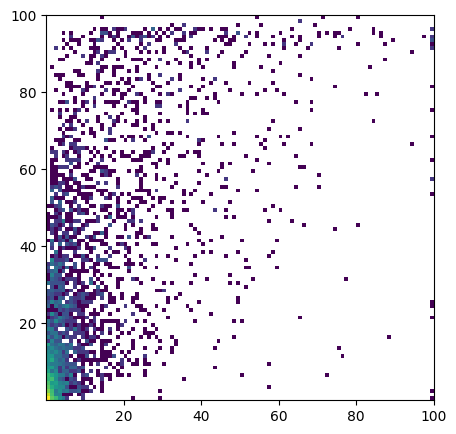

In [43]:
# Now a 2d distribution plot of overlap_percent and occurrence_percentage
from matplotlib.colors import LogNorm

df = pd.read_sql_query("SELECT mean_overlap, ocurrence_percentage FROM PIXEL_OVERLAPS", new_conn)

fig, ax = plt.subplots(figsize=(5, 5))

a = ax.hist2d(df["mean_overlap"], df["ocurrence_percentage"], bins=100, norm=LogNorm())

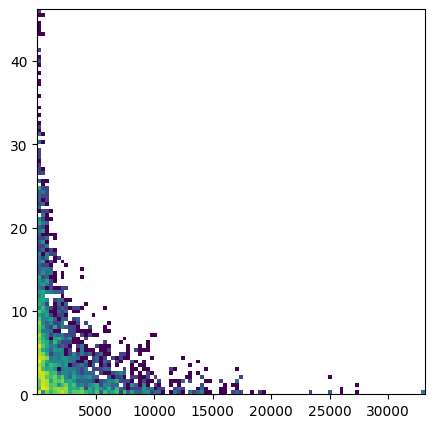

In [44]:
# What about pixel area vs avg overlap
from matplotlib.colors import LogNorm

df = pd.read_sql_query("""
    SELECT mean_overlap, ocurrence_percentage, std_overlap, H.pix_area FROM PIXEL_OVERLAPS
    INNER JOIN HARPS H
    ON H.harpnum = PIXEL_OVERLAPS.harpnum_a 
""", new_conn)


fig, ax = plt.subplots(figsize=(5, 5))

a = ax.hist2d(df["pix_area"], df["std_overlap"], bins=100, norm=LogNorm())

(array([[23.,  4.,  2., ...,  0.,  0.,  0.],
        [13., 49., 44., ...,  0.,  0.,  0.],
        [ 0., 12., 96., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([  3.  ,   5.87,   8.74,  11.61,  14.48,  17.35,  20.22,  23.09,
         25.96,  28.83,  31.7 ,  34.57,  37.44,  40.31,  43.18,  46.05,
         48.92,  51.79,  54.66,  57.53,  60.4 ,  63.27,  66.14,  69.01,
         71.88,  74.75,  77.62,  80.49,  83.36,  86.23,  89.1 ,  91.97,
         94.84,  97.71, 100.58, 103.45, 106.32, 109.19, 112.06, 114.93,
        117.8 , 120.67, 123.54, 126.41, 129.28, 132.15, 135.02, 137.89,
        140.76, 143.63, 146.5 , 149.37, 152.24, 155.11, 157.98, 160.85,
        163.72, 166.59, 169.46, 172.33, 175.2 , 178.07, 180.94, 183.81,
        186.68, 189.55, 192.42, 195.29, 198.16, 201.03, 203.9 , 206.77,
        209.64, 212.51, 215.38, 218.25, 221.12, 223.99, 226.86, 229

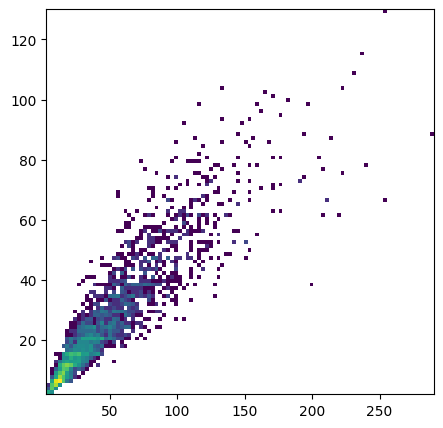

In [8]:
# Make a 2d distribution plot using the HARPS table values of pix_width and pix_height

from matplotlib.colors import LogNorm

df = pd.read_sql_query("SELECT pix_width, pix_height FROM HARPS WHERE pix_width IS NOT NULL AND pix_height IS NOT NULL", new_conn)

df["pix_width"] = df["pix_width"].astype(int)
df["pix_height"] = df["pix_height"].astype(int)

# Now plot, log scale for the z axis

fig, ax = plt.subplots(figsize=(5, 5))

ax.hist2d(df["pix_width"], df["pix_height"], bins=100, norm=LogNorm())

(array([[1472.,    0.,    0., ...,    0.,    0.,    0.],
        [ 537.,    3.,    0., ...,    0.,    0.,    0.],
        [ 258.,   68.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([    0.,   300.,   600.,   900.,  1200.,  1500.,  1800.,  2100.,
         2400.,  2700.,  3000.,  3300.,  3600.,  3900.,  4200.,  4500.,
         4800.,  5100.,  5400.,  5700.,  6000.,  6300.,  6600.,  6900.,
         7200.,  7500.,  7800.,  8100.,  8400.,  8700.,  9000.,  9300.,
         9600.,  9900., 10200., 10500., 10800., 11100., 11400., 11700.,
        12000., 12300., 12600., 12900., 13200., 13500., 13800., 14100.,
        14400., 14700., 15000., 15300., 15600., 15900., 16200., 16500.,
        16800., 17100., 17400., 17700., 18000., 18300., 18600., 18900.,
        19200., 19500., 19800., 20100., 20400., 20700., 21000., 213

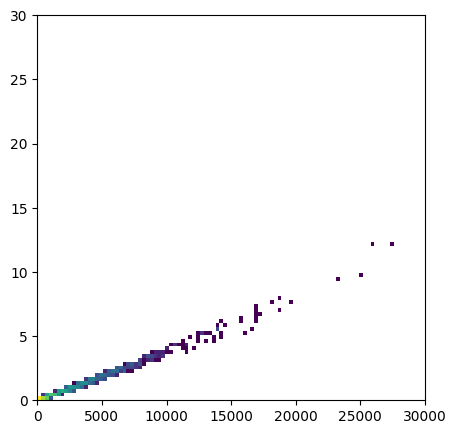

In [24]:
# What about same but pixel area vs area

df = pd.read_sql_query("SELECT pix_width * pix_height as pix_area, area FROM HARPS WHERE pix_width IS NOT NULL AND pix_height IS NOT NULL", new_conn)

df["pix_area"] = df["pix_area"].astype(int)
df["area"] = df["area"]


# Now plot, log scale for the z axis and for y axis also log scale

fig, ax = plt.subplots(figsize=(5, 5))

ax.hist2d(df["pix_area"], df["area"], bins=100, range=[[0,30000],[0,30]], norm=LogNorm())

In [35]:
import sunpy.map as smap

sample_header = sdoml_timestamp_info["2011-02-15 00:00:00"]["header"]

# Get sun size in pixels
r_sun = sample_header["RSUN_OBS"] / sample_header["CDELT1"]

# So the sun starts at
x0 = sample_header["CRPIX1"] - r_sun
sample_header["CRPIX1"]
x0

# And it ends at

x1 = sample_header["CRPIX1"] + r_sun

x0, x1

(53.16666666666666, 459.83333333333337)

In [4]:
new_cur.execute("DROP TABLE IF EXISTS HOURLY_PIXEL_BBOX;")
new_cur.execute("""
CREATE TABLE HOURLY_PIXEL_BBOX AS
SELECT * FROM PROCESSED_HARPS_PIXEL_BBOX PHPBB
WHERE strftime("%M", timestamp) IN ("00", "12", "24")
GROUP BY harpnum, strftime("%Y %m %d %H", timestamp)
""")